## High Dynamic Range (HDR) Imaging

In [3]:
pip install exifread

In [4]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import exifread  #The ExifRead library reads the image file in binary mode and extracts the EXIF metadata.

In [5]:
# Load the image using OpenCV (optional step if you only need metadata)
#image_path = '1.jpg'  # 1/30
#image_path = '2.jpg'  # 1/1250
#image_path = '3.jpg'  # 1/50
#image_path = '4.jpg'  # 1/800
#image_path = '5.jpg'   # 1/80
#image_path = '6.jpg'   # 1/500
#image_path = '7.jpg'   # 1/125
#image_path = '8.jpg'   # 1/320
image_path = '9.jpg'   # 1/200

img = cv2.imread(image_path)

# Open the image file for reading (binary mode)
with open(image_path, 'rb') as f:
    # Return Exif tags
    tags = exifread.process_file(f)

# Extract the exposure time
exposure_time = tags.get('EXIF ExposureTime')

# Print the exposure time
if exposure_time:
    print(f"Exposure Time: {exposure_time}")
else:
    print("Exposure Time not found in the metadata.")

Exposure Time: 1/200


**Explanation:**

1. Loading the image: This step is optional if you only need to read the metadata and not process the image with OpenCV.
2. Reading the image metadata: The ExifRead library reads the image file in binary mode and extracts the EXIF metadata.
3. Extracting the exposure time: The script retrieves the exposure time from the metadata using the tag `EXIF ExposureTime`.

**Basic Idea**

1. The dynamic range of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0


**Step 1: Capture Multiple Exposures**

In [6]:
def readImagesAndTimes():
    # List of file names
    filenames = ["1.jpg", "2.jpg", "3.jpg", "4.jpg","5.jpg","6.jpg","7.jpg","8.jpg","9.jpg"]
    # filenames = ["1.jpg","3.jpg","5.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 1250.0, 50.0, 800.0,80.0,500.0,125.0,320.0,200.0], dtype=np.float32)
    # times = np.array([1 / 30.0, 50.0, 80.0],dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

**Step 2: Align Images**

In [7]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

**AlignMTB**

1. MTB stands for Median Threshold Bitmap.
2. This class is used to align multiple images of the same scene, typically captured at different exposures, by shifting them so that they match up perfectly.
3. It helps to remove any misalignments due to slight movements of the camera between shots.
4. The `AlignMTB` algorithm is particularly useful in HDR imaging where several images with different exposure levels are combined.


**Step 3: Estimate Camera Response Function**

What is CalibrateDebevec?


---
`CalibrateDebevec` is a tool in OpenCV used to understand how a camera reacts to light. Different cameras can react differently to the same amount of light, and this tool helps figure out that reaction.

---

1. When you take multiple photos of the same scene with different exposure settings (some brighter, some darker), you can combine them into one image with more details (HDR image).
2. `x = np.arange(256, dtype=np.uint8)`: Creates an array of pixel values ranging from 0 to 255. These represent the measured pixel values.
3. `y = np.squeeze(responseDebevec)`: Squeezes the response function array to remove any singleton dimensions, making it easier to plot.
4. `plt.xlim([0, 260])`: Sets the x-axis limits to range from 0 to 260.
5. `plt.plot(x, y[:, 0], "r", x, y[:, 1], "g", x, y[:, 2], "b")`: Plots the inverse camera response function for the red, green, and blue channels.
* x: Measured pixel values (0-255).
* y[:, 0]: Calibrated intensity values for the red channel.
* y[:, 1]: Calibrated intensity values for the green channel.
* y[:, 2]: Calibrated intensity values for the blue channel.
* "r", "g", "b": Specifies the colors of the plots (red, green, and blue, respectively).




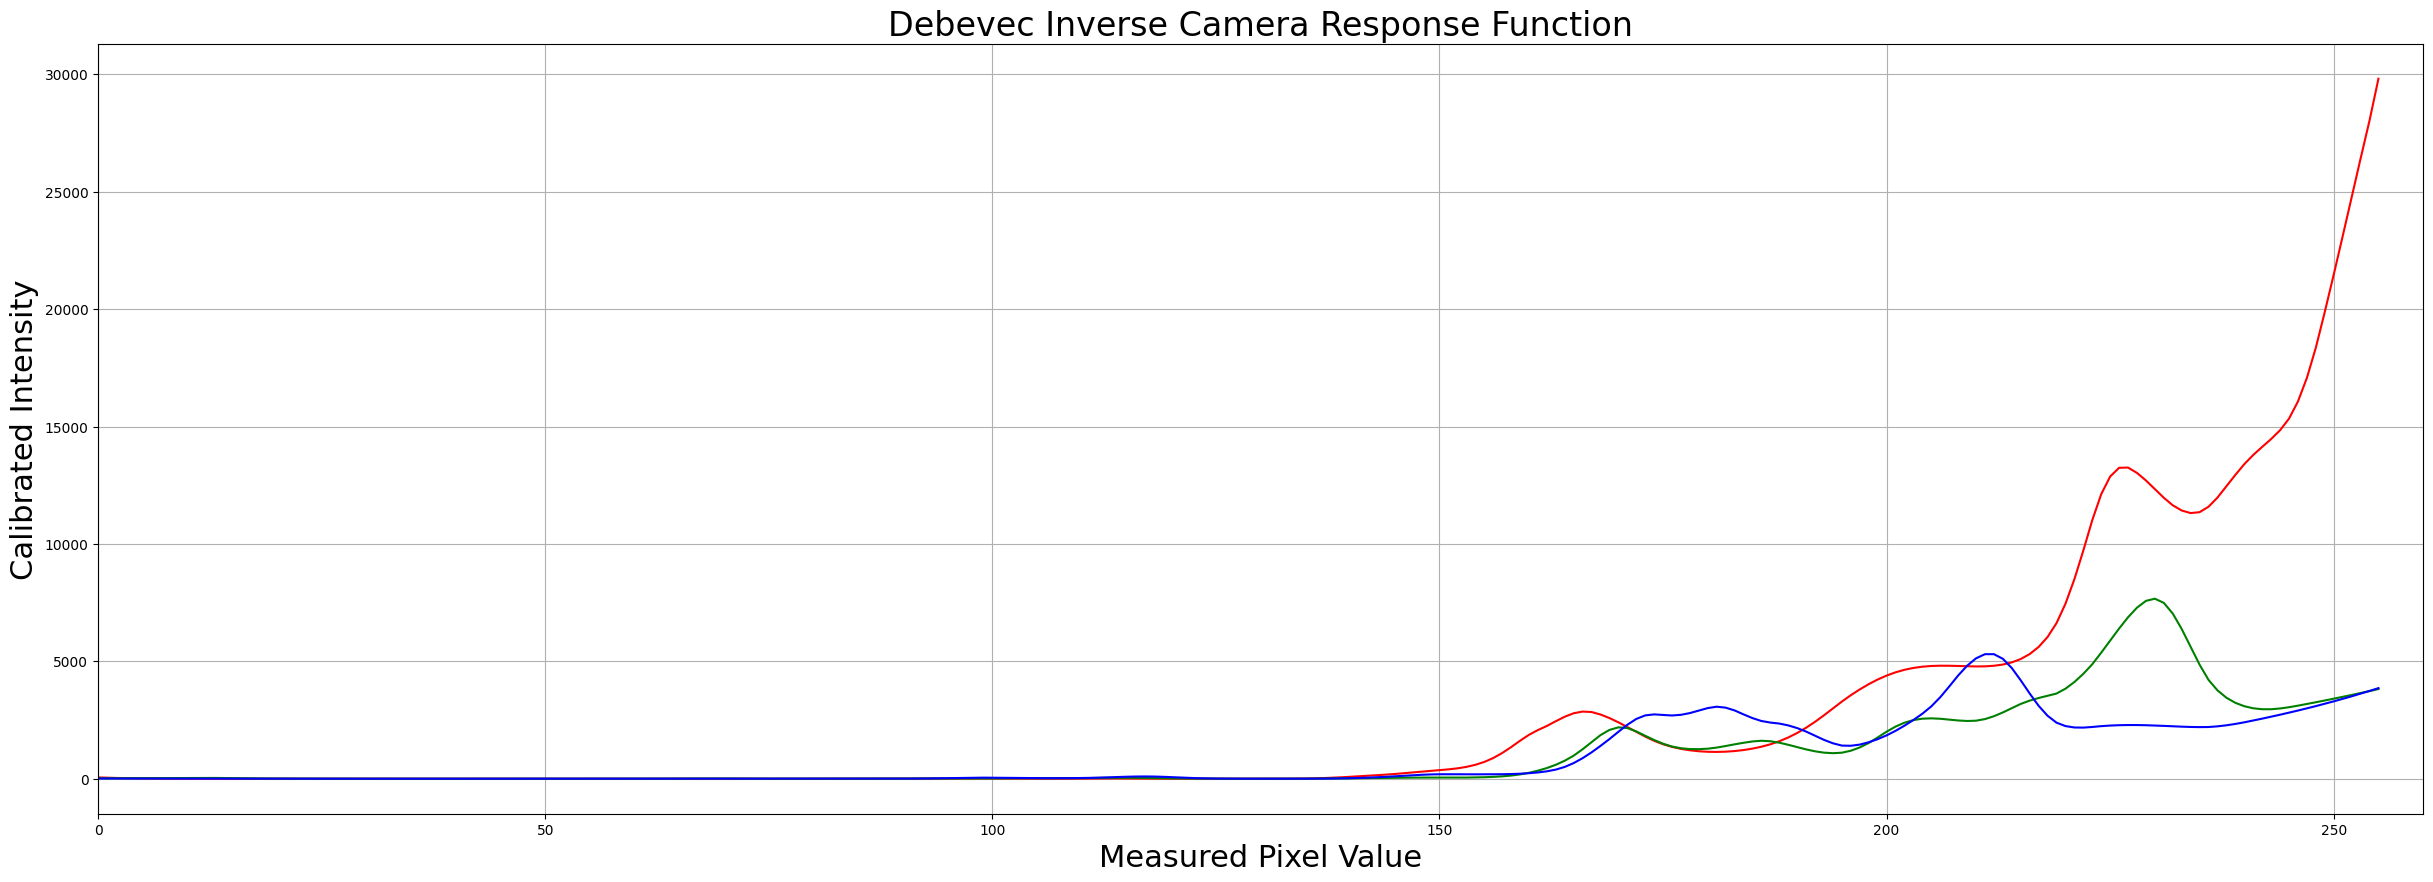

In [8]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid() # Adds a grid to the plot
plt.plot(x, y[:, 0], "r", x, y[:, 1], "g", x, y[:, 2], "b")

**Step 4: Merge Exposure into an HDR Image**

`MergeDebevec`: This class implements the method proposed by Paul Debevec and Jitendra Malik for merging images into an HDR image. It takes into account the camera response function to accurately merge images with different exposures.


In [9]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

**Step 5: Tonemapping**

What is Tonemapping Algorithm?


---
Tone mapping algorithms are used in image processing and computer graphics to convert high dynamic range (HDR) images to low dynamic range (LDR) images that can be displayed on conventional screens


---


Many Tonemapping algorithms are available in OpenCV. We chose Durand as it has more controls.

saved ldr-Drago.jpg


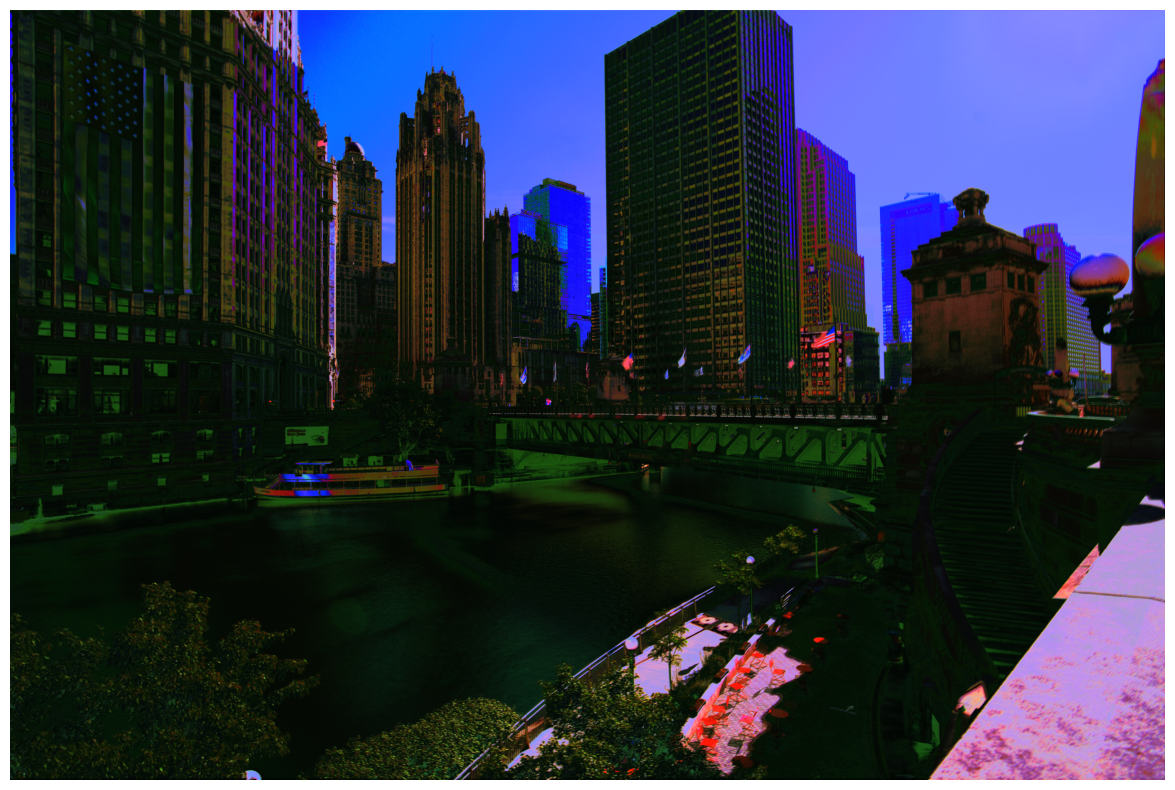

In [11]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

# # Ensure there are no NaN or infinity values
# ldrDrago = np.nan_to_num(ldrDrago, nan=0.0, posinf=1.0, neginf=0.0)

# Convert BGR to RGB for correct display with matplotlib
ldrDrago_rgb = cv2.cvtColor(ldrDrago, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago_rgb, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago_rgb[:, :, ::-1])
print("saved ldr-Drago.jpg")


`tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)`


---
This line of code is creating a tonemap operator using the Drago method, which is part of the process to convert a High Dynamic Range (HDR) image to a Low Dynamic Range (LDR) image. This makes the HDR image displayable on standard monitors, which cannot handle the full range of intensities present in an HDR image.
Parameters:
1. 1.0: This is the gamma parameter. It controls the gamma correction, which adjusts the overall brightness of the image. A gamma value of 1.0 means no gamma correction.
2. 0.7: This is the saturation parameter. It controls the saturation of the image. A value of 0.7 means the resulting image will be somewhat desaturated, which can help in managing the contrast and preserving details in the tonemapped image.


Tonemaping using Reinhard's method ... 
saved ldr-Reinhard.jpg


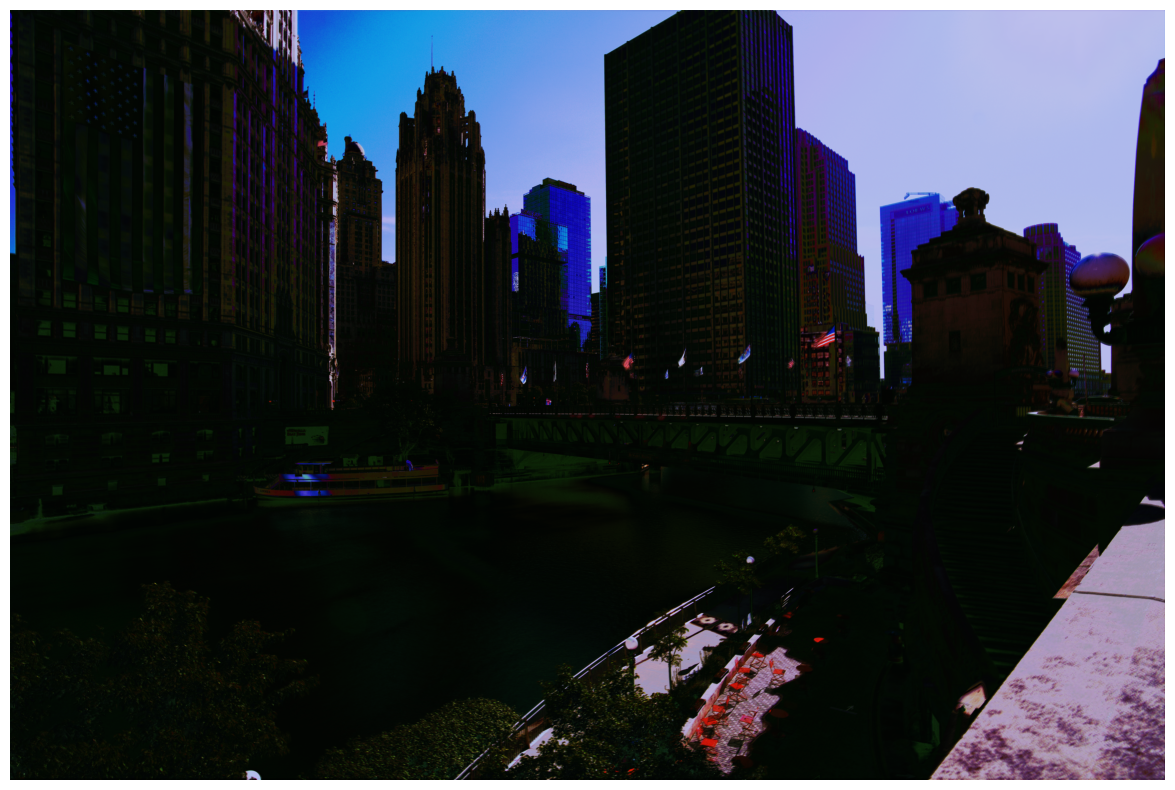

In [13]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

# Convert BGR to RGB for correct display with matplotlib
ldrReinhard_rgb = cv2.cvtColor(ldrReinhard, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard_rgb, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard_rgb * 255)
print("saved ldr-Reinhard.jpg")

`tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)`

Parameters:

1. 1.5: This is the gamma parameter. It controls the overall brightness of the image. A gamma value of 1.0 means no gamma correction, while values greater than 1.0 will make the image brighter.
2. 0: This is the intensity parameter. It controls the global intensity of the resulting image. A value of 0 means no adjustment.
3. 0: This is the light_adapt parameter. It controls the light adaptation, which affects how much the algorithm adapts to the brightness of the scene. A value of 0 means full adaptation to the average scene luminance.
4. 0: This is the color_adapt parameter. It controls the color adaptation, which affects how much the colors are preserved in the resulting image. A value of 0 means no color adaptation.

Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


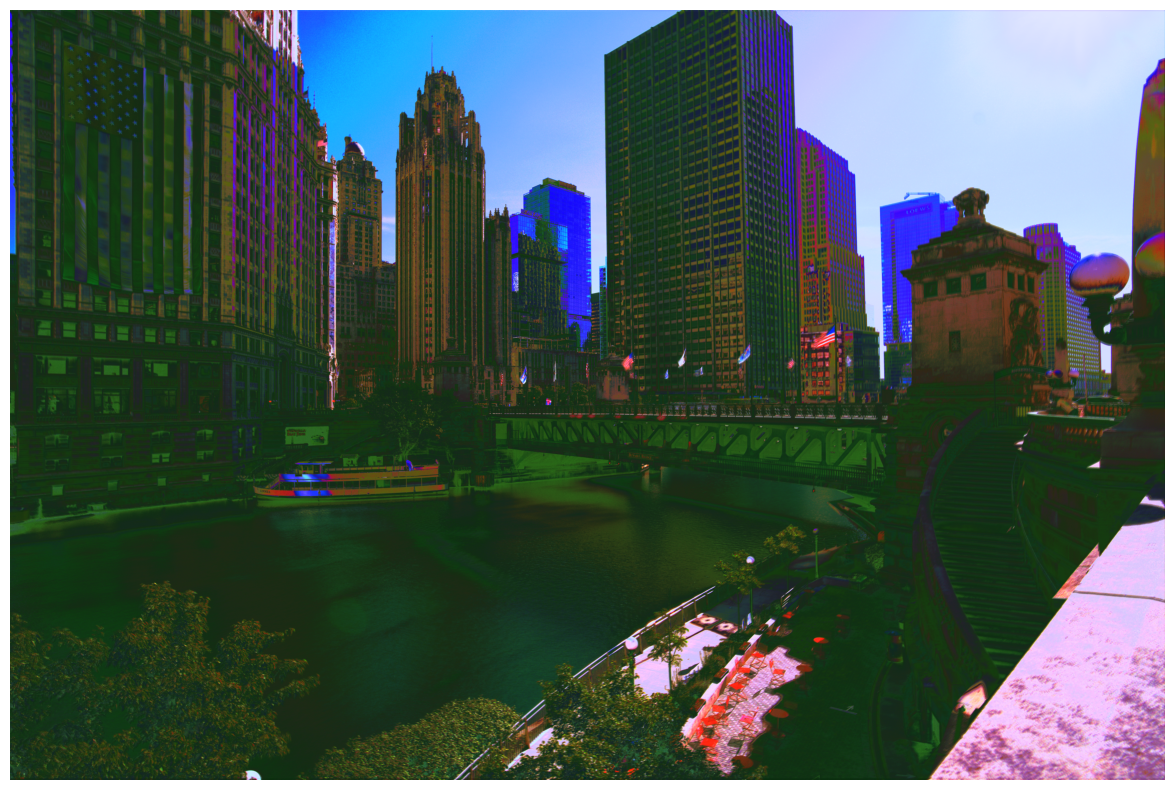

In [14]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

# Convert BGR to RGB for correct display with matplotlib
ldrMantiuk_rgb = cv2.cvtColor(ldrMantiuk, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk_rgb, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk_rgb * 255)
print("saved ldr-Mantiuk.jpg")

`tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)`
Parameters:
1. 2.2: This is the scale parameter. It controls the contrast scale of the image. A higher value results in higher contrast and more pronounced details.
2. 0.85: This is the saturation parameter. It controls the color saturation of the image. A value of 0.85 means the resulting image will be slightly desaturated.
3. 1.2: This is the gamma parameter. It controls the gamma correction, which adjusts the overall brightness of the image. A gamma value of 1.2 means the image will be slightly brighter.